In this project, the objective is to detect whether the door of a room is opened or not by analyzing the abnormal temperature variations during the recorded time intervals. To begin, the recorded temperature data will be plotted to visually inspect any noticeable patterns or abnormalities. Next, the K-means clustering algorithm will be applied to partition the data into distinct clusters, enabling the identification of any abnormal clusters that may indicate the door being opened.


In [12]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score

from scipy.spatial.distance import cdist


# 1. EDA

In [14]:
## Read data
filepath = '/content/sample_data/'
df = pd.read_csv(filepath + "room-temperature.csv")
N = len(df)
df.head()

,Date,FrontLeft,FrontRight,BackLeft,BackRight
0,4/11/2010 11:30,295.2,297.0,295.8,296.3
1,4/11/2010 12:00,296.2,296.4,296.2,296.3
2,4/11/2010 12:30,297.3,297.5,296.7,297.1
3,4/11/2010 13:00,295.9,296.7,297.4,297.0
4,4/11/2010 13:30,297.2,296.5,297.6,297.4


In [42]:
print(N, "observations")
print("Time frame: {}-{}".format(df.iloc[0,0], df.iloc[-1,0]))

144 observations
Time frame: 4/11/2010 11:30-4/14/2010 11:00


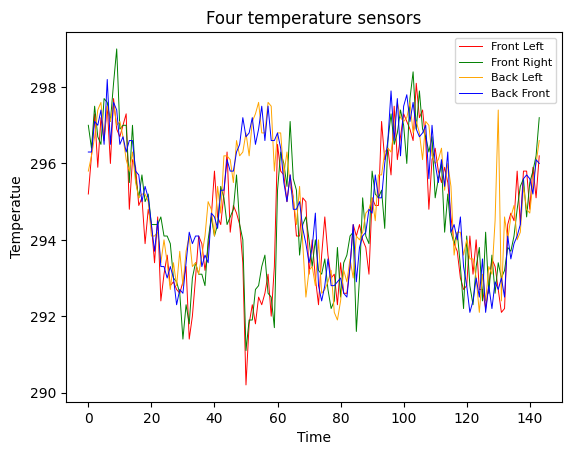

In [30]:
## Plot data
plt.plot(df.index,df.iloc[:,1], color = 'red', linewidth = 0.7, label = 'Front Left')
plt.plot(df.index,df.iloc[:,2], color = 'green', linewidth = 0.7, label = 'Front Right')
plt.plot(df.index,df.iloc[:,3], color = 'orange', linewidth = 0.7, label = 'Back Left')
plt.plot(df.index,df.iloc[:,4], color = 'blue', linewidth = 0.7, label = 'Back Front')
plt.legend(fontsize = 8)
plt.ylabel('Temperatue')
plt.xlabel('Time')
plt.title('Four temperature sensors')
plt.show()

Temperatures at the front-left and front-right side suddenly drop between time interval 40-60 and generate a huge gap between temperatute of front and back side at this time. The rest of the time, back and front temperatures share the same pattern.

In [29]:
df.loc[40,'Date'], df.loc[60,'Date']

('4/12/2010 7:30', '4/12/2010 17:30')

# 2. Kmean and PCA

## 2.1. PCA

In order to enable easier visualization and interpretation of the temperature data, PCA is applied to reduce the dataset from its original 4 dimensions to 2 dimensions.

In [9]:
reduced_data = PCA(n_components=2).fit_transform(df.iloc[:,1:])

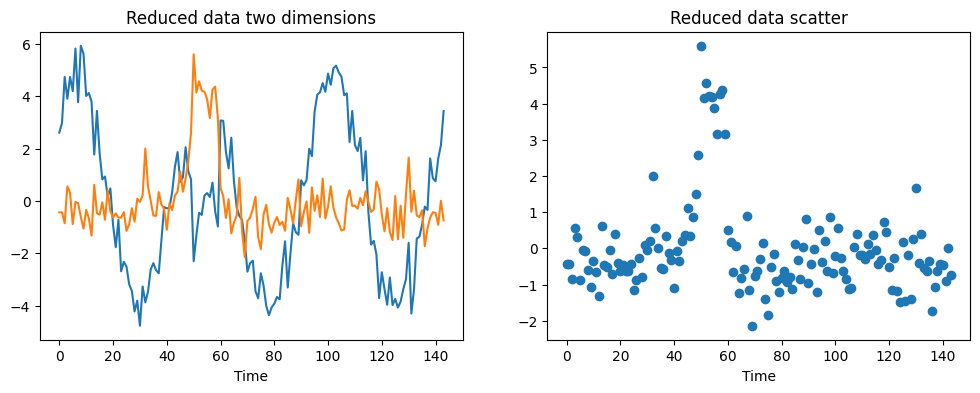

In [24]:
fig, axes = plt.subplots(1,2,figsize = (12,4))
axes[0].plot(np.arange(N),reduced_data[:,0])
axes[0].plot(np.arange(N),reduced_data[:,1])
axes[0].set_title('Reduced data two dimensions')
axes[0].set_xlabel('Time')

axes[1].scatter(np.arange(N),reduced_data[:,1])
axes[1].set_title('Reduced data scatter')
axes[1].set_xlabel('Time')
plt.show()

We can see that reduced data can keep characteristics of original data. There is a abnormal pattern emerges within the time interval of 40-60 when the orange line suddenly jump up.

## 2.2. Kmean++

Kmean ++ is applied for different number of clusters (2,3,4,5,6).

In [7]:
def plot_kmeans(X,k,labels,centroids):
# plot kmeans clusters in different colors
    colors = ["green","blue","orange","cyan","black","yellow","purple"]
    markers = ["o","+","*","x","v","square","diamond","^"]

    for j in range(k):
        plt.scatter(X[labels == j,0], X[labels == j,1], color = colors[j], s = 40
                    , label = 'cluster {}'.format(j+1))
    plt.scatter(centroids[:,0], centroids[:,1], marker = "^", color = 'red', s = 100
                , label = 'centroids')
    plt.title('{} clusters'.format(k))
    plt.legend(fontsize = 8)
    plt.show()

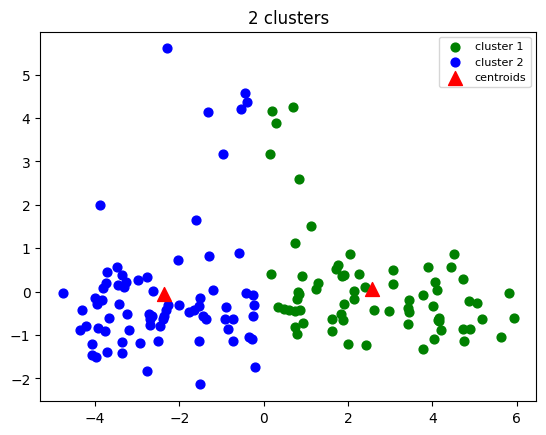

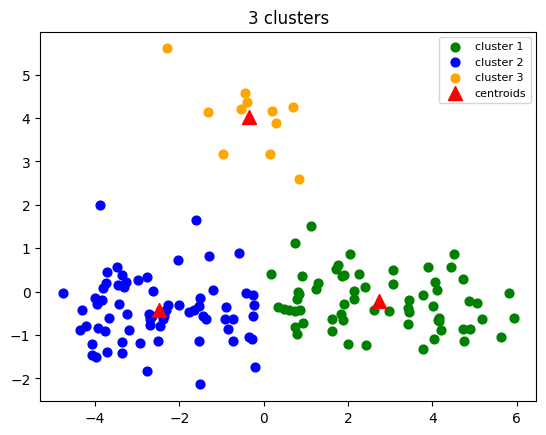

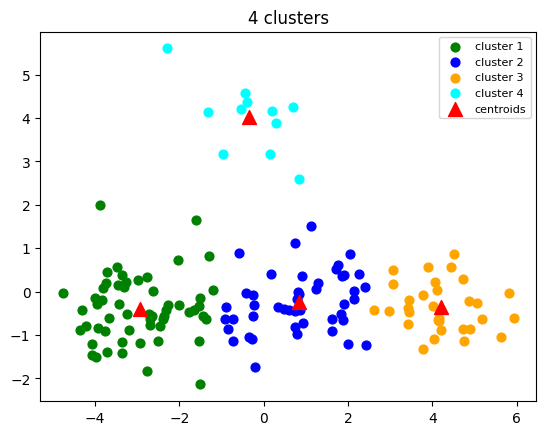

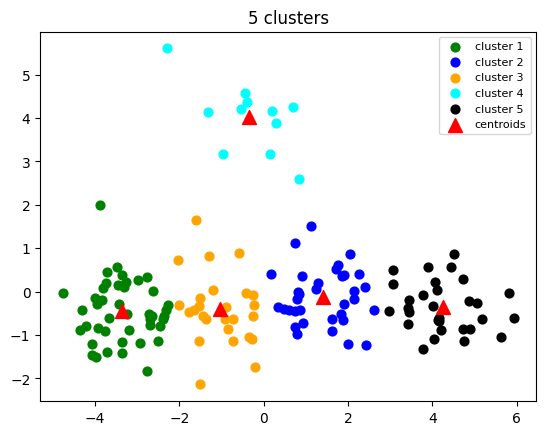

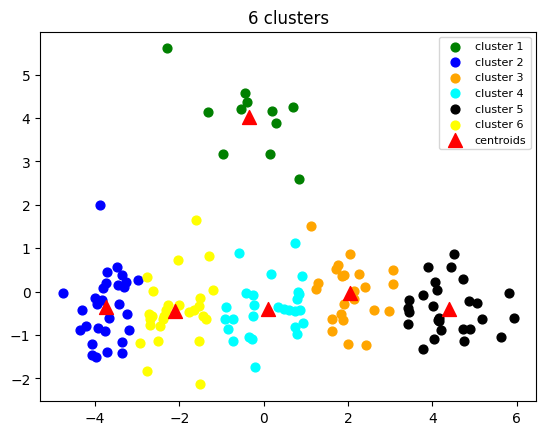

In [10]:
distortions = [] #elbow
silhouettes = [] #solhouettes scores
K = (2,3,4,5,6)
for k in K:
  model = KMeans(init='k-means++', n_clusters=k, n_init=10)
  model.fit(reduced_data)
  centroids = model.cluster_centers_
  labels = model.labels_
  plot_kmeans(reduced_data,k,labels,centroids)
  distortions.append(sum(np.min(cdist(reduced_data, centroids,
                                        'euclidean'), axis=1)) / N)
  silhouettes.append(silhouette_score(reduced_data, labels))

Choose optimal number of clusters

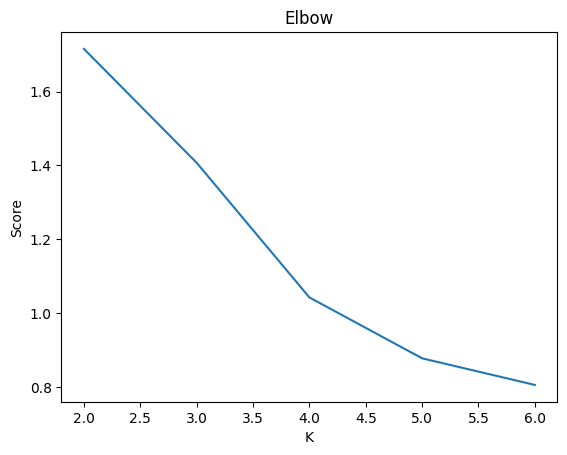

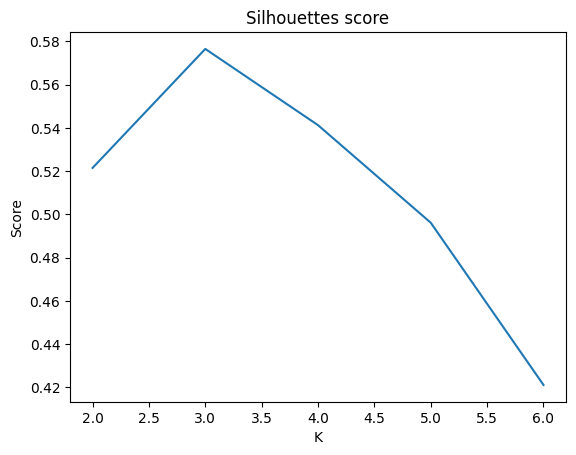

In [11]:
plt.plot(K,distortions)
plt.title('Elbow')
plt.xlabel('K')
plt.ylabel('Score')
plt.show()
plt.plot(K,silhouettes)
plt.title('Silhouettes score')
plt.xlabel('K')
plt.ylabel('Score')
plt.show()

To decide the optimal number of clusters, the Elbow method and Silhouette scores are employed:
- Elbow: It computes Sum of Squared Errors (SSE) by sum squared distances between each point and its centroid within each cluster. The optimal number of clusters is the "elbow" point, which represents a significant drop in SSE. This point indicates a good balance between the number of clusters and the compactness of data within each cluster.
- Silhouette: The Silhouette method computes the Silhouette coefficient for each sample in the dataset. The Silhouette coefficient measures the cohesion (how similar a sample is to its own cluster) and separation (how dissimilar a sample is to other clusters) of each sample. Average Silhouette coefficient for each number of clusters are generated. A higher Silhouette coefficient indicates better clustering, with values ranging from -1 to 1. A value close to 1 suggests well-separated clusters, while a value close to -1 indicates that samples may have been assigned to the wrong cluster.

The Elbow graph below shows that it may not exhibit clear breakpoints. Therefore, we Elbow could not be suitable for this case. In our case, the Silhouette graph reveals that K-means with k=3 achieves the highest score, suggesting that 3 clusters are optimal for the data.

Lets have a look at Kmean with k = 3. There is  a distinct cluster depicted in orange color that is separated from the other two clusters. This distinct group, positioned above the other two, provides evidence of abnormal temperature patterns within the dataset

# 3. Conclusion

Based on EDA analysis and Kmean clustering, there is trong evidence indicating the presence of abnormal temperature patterns at the front side during the time interval 40-60. The front door is opened betwwen '4/12/2010 7:30' - '4/12/2010 17:30'.